# Optimizadores

Hasta ahora cada vez que hemos entrenado una red hemos usado como optimizador `torch.optim.SGD`, es decir, el descenso del gradiente estocástico (stochastic gradient descent SGD). Pero cuando vimos la teoría de cómo funciona una red neuronal solo hablamos del descenso del gradiente. Vamos a ver en qué se diferencian ambos

Como hemos visto, dividimos el dataset de datos en batches para meterle a la red el mayor número de datos a la vez. Y hemos visto que cuanto mayor es el tamaño de cada batch mejor, la red obtiene mejores resultados. En un caso ideal, lo mejor es meterle a la red todos los datos del dataset, pero esto normalmente no es posible, por eso se divide en batches, porque normalmente hay muchos más datos que capacidad tiene la red

Vamos a ver la diferencia de entrenar una red metiendo todos los datos en la memoria de la GPU, metiendo batches y metiendo cada vez solo un dato

Vamos a verlo con el ejemplo del dataset Cancer

In [1]:
from sklearn import datasets
import pandas as pd

cancer = datasets.load_breast_cancer()
cancer_df = pd.DataFrame(cancer['data'], columns=cancer['feature_names'])
cancer_df['type'] = cancer['target']
cancer_df.head()

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension,type
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,0
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,0
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,0
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,...,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,0
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,...,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,0


In [2]:
import torch

class CancerDataset(torch.utils.data.Dataset):
    def __init__(self, dataframe):
        cols = [col for col in dataframe.columns if col != 'target']
        self.parameters = torch.from_numpy(dataframe[cols].values).type(torch.float32)
        self.targets = torch.from_numpy(dataframe['type'].values).type(torch.float32)
        self.targets = self.targets.reshape((len(self.targets), 1))

    def __len__(self):
        return len(self.parameters)

    def __getitem__(self, idx):
        parameters = self.parameters[idx]
        target = self.targets[idx]
        return parameters, target

ds = CancerDataset(cancer_df)
train_ds, valid_ds = torch.utils.data.random_split(ds, [int(0.8*len(ds)), len(ds) - int(0.8*len(ds))], generator=torch.Generator().manual_seed(42))

In [3]:
from torch import nn

class CancerNeuralNetwork(nn.Module):
    def __init__(self, num_inputs, num_outputs, hidden_layers=[100, 50, 20]):
        super().__init__()
        self.network = torch.nn.Sequential(
            torch.nn.Linear(num_inputs, hidden_layers[0]),
            torch.nn.ReLU(),
            torch.nn.Linear(hidden_layers[0], hidden_layers[1]),
            torch.nn.ReLU(),
            torch.nn.Linear(hidden_layers[1], hidden_layers[2]),
            torch.nn.ReLU(),
            torch.nn.Linear(hidden_layers[2], num_outputs),
        )
        self.activation = torch.nn.Sigmoid()

    def forward(self, x):
        logits = self.network(x)
        probs = self.activation(logits)
        return logits, probs

# Get cpu or gpu device for training.
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using {} device".format(device))

Using cuda device


In [4]:
from torch.utils.data import DataLoader

BS_train = len(train_ds)
train_dl = DataLoader(train_ds, batch_size=BS_train, shuffle=True)

model = CancerNeuralNetwork(num_inputs=31, num_outputs=1).to(device)

In [5]:
LR = 1e-3
loss_fn = nn.BCELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=LR)

In [7]:
def train_loop(dataloader, model, loss_fn, optimizer, epochs, num_prints=4):
    size = len(dataloader.dataset)
    model.train()

    losses = []
    iteration = []
    iter = 0

    for t in range(epochs):
        print(f"Epoch {t+1}\n-------------------------------")
        for batch, (X, y) in enumerate(dataloader):
            # X and y to device
            X, y = X.to(device), y.to(device)

            # Compute prediction and loss
            logits, probs = model(X)
            loss = loss_fn(probs, y)

            # Add to lists
            losses.append(loss.item())
            iteration.append(iter)
            iter += 1

            # Backpropagation
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            if batch % (int(len(dataloader)/num_prints)+1) == 0:
                loss, current = loss.item(), batch * len(X)
                print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")
    print("Done!")

    return losses, iteration

Epoch 1
-------------------------------
loss: 0.965165  [    0/  455]
Epoch 2
-------------------------------
loss: 2.248273  [    0/  455]
Epoch 3
-------------------------------
loss: 2.324464  [    0/  455]
Epoch 4
-------------------------------
loss: 0.790592  [    0/  455]
Epoch 5
-------------------------------
loss: 1.740439  [    0/  455]
Epoch 6
-------------------------------
loss: 0.714093  [    0/  455]
Epoch 7
-------------------------------
loss: 1.385249  [    0/  455]
Epoch 8
-------------------------------
loss: 0.659133  [    0/  455]
Epoch 9
-------------------------------
loss: 1.063710  [    0/  455]
Epoch 10
-------------------------------
loss: 0.701113  [    0/  455]
Epoch 11
-------------------------------
loss: 1.131021  [    0/  455]
Epoch 12
-------------------------------
loss: 0.565366  [    0/  455]
Epoch 13
-------------------------------
loss: 0.763951  [    0/  455]
Epoch 14
-------------------------------
loss: 0.632293  [    0/  455]
Epoch 15
------

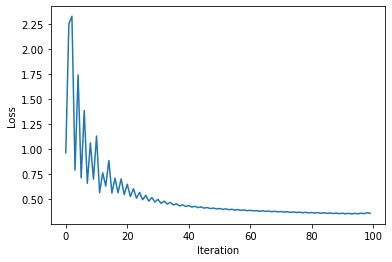

In [8]:
losses, iteractions = train_loop(train_dl, model, loss_fn, optimizer, epochs=100)

# Plot loss vs. iteration
import matplotlib.pyplot as plt
plt.plot(iteractions, losses)
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.show()